In [2]:
from time import time
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.elementwise import ElementwiseKernel
plt.style.use('dark_background')

In [3]:
def simple_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):
    
    real_vals = np.linspace(real_low, real_high, width)
    imag_vals = np.linspace(imag_low, imag_high, height)
    
    mandelbrot_graph = np.ones((height,width), dtype=np.float32)
    
    for x in range(width):
        for y in range(height):
            c = np.complex64( real_vals[x] + imag_vals[y] * 1j  )            
            z = np.complex64(0)
            
            for i in range(max_iters):                
                z = z**2 + c
                if(np.abs(z) > upper_bound):
                    mandelbrot_graph[y,x] = 0
                    break
                
    return mandelbrot_graph

In [4]:
# t1 = time()
# mandel = simple_mandelbrot(512, 512, -2, 2, -2, 2, 512, 2.5)
# t2 = time()
# mandel_time = t2 - t1

# t1 = time()
# fig = plt.figure(1)
# plt.imshow(mandel, extent=(-2, 2, -2, 2))
# plt.show()
# t2 = time()
# dump_time = t2 - t1

#mandel_time, dump_time

In [5]:
#notice C types correspond to specific np dtypes
#this algorithm is parallelized only over i (not j)
#inside the kernel the arrays will also be flattened.

mandel_ker = ElementwiseKernel(
"pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
"""
mandelbrot_graph[i] = 1;

pycuda::complex<float> c = lattice[i]; 
pycuda::complex<float> z(0,0);

for (int j = 0; j < max_iters; j++)
    {
    
     z = z*z + c;
     
     if(abs(z) > upper_bound)
         {
          mandelbrot_graph[i] = 0;
          break;
         }

    }
         
""",
"mandel_ker")

def gpu_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):

    # we set up our complex lattice as such
    real_vals = np.matrix(np.linspace(real_low, real_high, width), dtype=np.complex64)
    imag_vals = np.matrix(np.linspace( imag_high, imag_low, height), dtype=np.complex64) * 1j
    mandelbrot_lattice = np.array(real_vals + imag_vals.transpose(), dtype=np.complex64)    
    

    mandelbrot_lattice_gpu = gpuarray.to_gpu(mandelbrot_lattice)
    mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice.shape, dtype=np.float32)
    
    mandel_ker(mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound))          
    mandelbrot_graph = mandelbrot_graph_gpu.get()
    
    return mandelbrot_graph

<IPython.core.display.Javascript object>


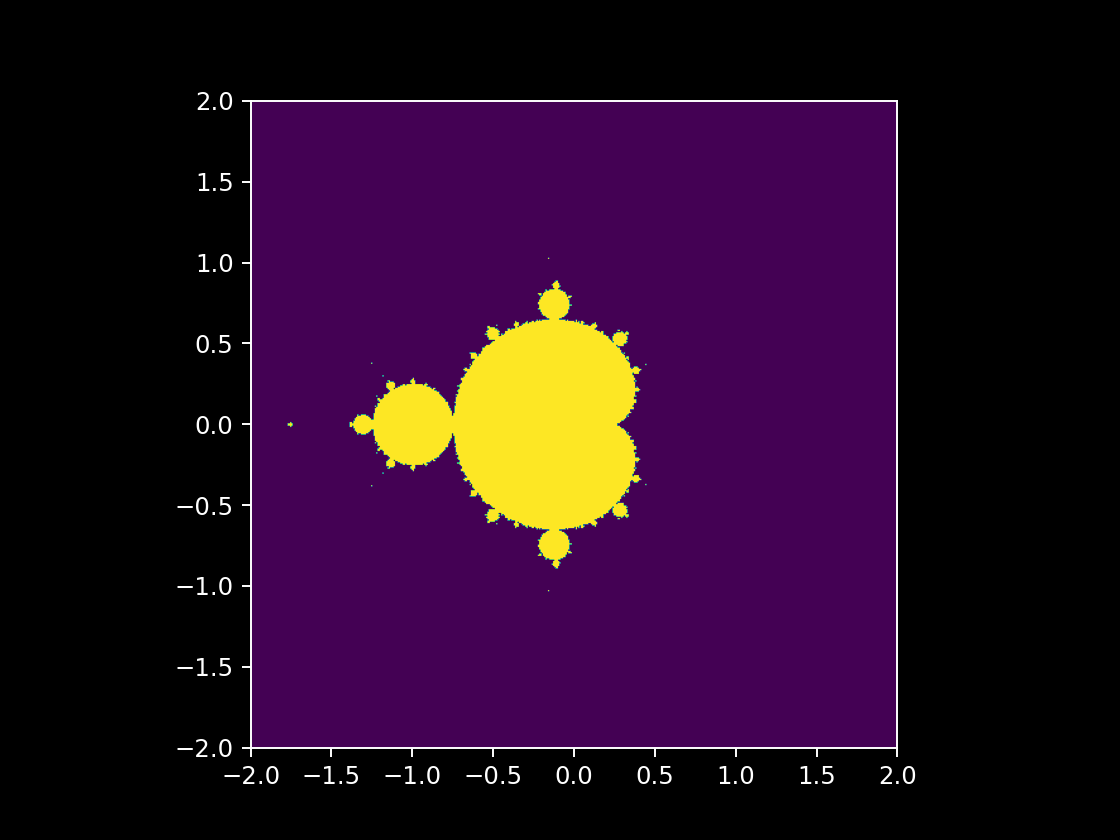

(4.833902835845947, 0.023020267486572266)

In [6]:
t1 = time()
mandel = gpu_mandelbrot(512, 512, -2, 2, -2, 2, 512, 2.5)
t2 = time()
mandel_time = t2 - t1

t1 = time()
fig = plt.figure(1)
plt.imshow(mandel, extent=(-2, 2, -2, 2))
plt.show()
t2 = time()
dump_time = t2 - t1

mandel_time, dump_time

In [28]:
#%matplotlib notebook
%matplotlib inline

In [8]:
def time_(mandel_func, arguments):
    t1 = time()
    mandel = mandel_func(*arguments)
    t2 = time()
    mandel_time = t2 - t1
    return mandel_time

arguments = [512, 512, -2, 2, -2, 2, 2048, 2.5]

In [9]:
time_(simple_mandelbrot, arguments)

59.30499815940857

In [10]:
time_(gpu_mandelbrot, arguments)

0.028024911880493164

In [11]:
%timeit time_(gpu_mandelbrot, arguments)

7.64 ms ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%run mandelbrot.py

3.7689332962036133


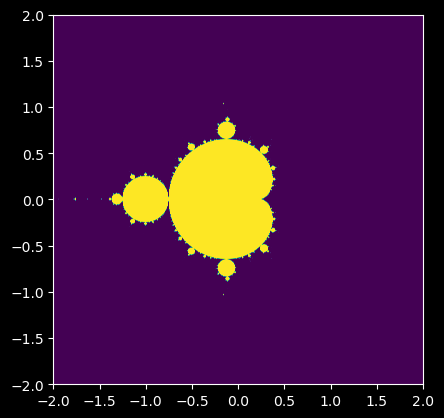

In [55]:
mandel = gpu_mandelbrot(4096*4, 4096*4, -2, 2, -2, 2, 4096, 2.5)

plt.imshow(mandel, extent=(-2, 2, -2, 2))
plt.show()

In [70]:
index_values = mandel.shape[0] // 3, mandel.shape[0] - mandel.shape[0] // 3
index_values

(5461, 10923)

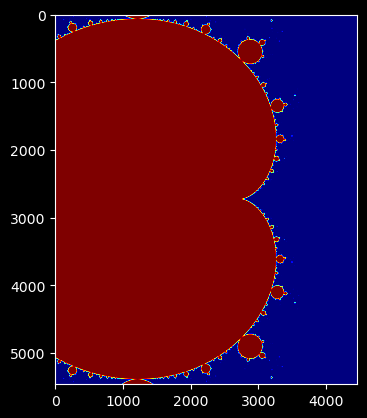

In [74]:
mandel_zoom = mandel[index_values[0]:index_values[1], index_values[0]+1000:index_values[1]]
plt.imshow(mandel_zoom, cmap='jet') # dat ass though